<a href="https://colab.research.google.com/github/NID123-CH/LLM-Codes/blob/main/Fine_Tune_Pig_Latin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate datasets peft trl bitsandbytes matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: tokenizers
   

## Harvard Sentences

Conditions of use: The material on this site is freely available for use in VoIP testing, research, development, marketing and any other reasonable application. The material may be copied, downloaded, broadcast, modified, incorporated into web sites or test equipment. We do require that you identify the source of the speech materials as "Open Speech Repository"..

https://www.cs.columbia.edu/~hgs/audio/harvard.html

## Pig Latin

In [ ]:
import re
from string import punctuation

def pig_latin(sentence):
    toks = [t.lower() for t in re.findall(r'\w+|[^\s\w]+', sentence) if len(t) > 0]

    def convert(string):
        # if starts with a vowel, just add "ay"
        # else move the consonants to the end and add "ay"
        if string in punctuation:
            return string
        elif string[0].lower() in {'a', 'e', 'i', 'o', 'u'}:
            return ' ' + string + 'way'
        else:
            beginning_consonants = []
            for i in range(len(string)):
                if string[i].lower() in {'a', 'e', 'i', 'o', 'u'}:
                    break
                beginning_consonants.append(string[i])
            return ' ' + string[i:] + ''.join(beginning_consonants) + 'ay'

    return ''.join([convert(t) for t in toks]).strip()

In [ ]:
pig_latin('How are you doing today?')

'owhay areway ouyay oingday odaytay?'

In [ ]:
!gdown 1pg8hJEdhiHjfcrvo3XzuW4d80xzqnFsl

Downloading...
From: https://drive.google.com/uc?id=1pg8hJEdhiHjfcrvo3XzuW4d80xzqnFsl
To: /content/harvard_sentences.txt
100% 30.5k/30.5k [00:00<00:00, 82.7MB/s]


### Load Harvard Sentences

In [ ]:
from datasets import load_dataset, Split
dataset = load_dataset(path='csv', data_files='harvard_sentences.txt', quotechar='"', split=Split.ALL)
dataset = dataset.shuffle().train_test_split(test_size=0.2)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 576
    })
    test: Dataset({
        features: ['sentence'],
        num_rows: 144
    })
})

In [ ]:
dataset['train'][0]

{'sentence': 'The sun came up to light the eastern sky.'}

### Translate Sentences to Pig Latin

In [ ]:
pig_ds = dataset.map(lambda s: {'translated': pig_latin(s['sentence'])})

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

In [ ]:
pig_ds['train'][1]

{'sentence': 'The wall phone rang loud and often.',
 'translated': 'ethay allway onephay angray oudlay andway oftenway.'}

### Prompt Dataset

In [ ]:
prompt_pig = pig_ds.rename_columns({'sentence': 'prompt', 'translated': 'completion'}).select_columns(['prompt', 'completion'])

In [ ]:
prompt_pig['train'][0]

{'prompt': 'The sun came up to light the eastern sky.',
 'completion': 'ethay unsay amecay upway otay ightlay ethay easternway yskyay.'}

## Tokenizer

In [ ]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
from trl import DataCollatorForCompletionOnlyLM

base_model_id = 'microsoft/phi-2'

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

1

In [ ]:
response_template = '##[PIGL]##>'
tokenizer.add_special_tokens({'additional_special_tokens': [response_template]})

len(tokenizer)

50297

In [ ]:
tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token

('<|pad|>', '<|endoftext|>', '<|endoftext|>')

In [ ]:
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

### Formatting

Let's build a formatting function that takes both prompt and completion, and inserts a particular string that will be used to trigger the translation. This string is the response template.

In [ ]:
def formatting_func(example):
    return f'{example["prompt"]}{response_template}{example["completion"]}' + tokenizer.eos_token

formatting_func(prompt_pig['train'][0])

'The sun came up to light the eastern sky.##[PIGL]##>ethay unsay amecay upway otay ightlay ethay easternway yskyay.<|endoftext|>'

In [ ]:
def generate_and_tokenize_prompt(prompt, max_length=128, padding=True):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length" if padding else False,
    )
    result["labels"] = result["input_ids"].copy()
    return result

dataset = prompt_pig['train'].map(lambda v: generate_and_tokenize_prompt(v, padding=False))
dataset = dataset.remove_columns(['prompt', 'completion'])
print(dataset[0])

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

{'input_ids': [50256, 464, 4252, 1625, 510, 284, 1657, 262, 10183, 6766, 13, 50296, 2788, 323, 5576, 323, 716, 721, 323, 510, 1014, 30972, 323, 220, 432, 10724, 4555, 323, 10183, 1014, 331, 15688, 323, 13, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [50256, 464, 4252, 1625, 510, 284, 1657, 262, 10183, 6766, 13, 50296, 2788, 323, 5576, 323, 716, 721, 323, 510, 1014, 30972, 323, 220, 432, 10724, 4555, 323, 10183, 1014, 331, 15688, 323, 13, 50256]}


576


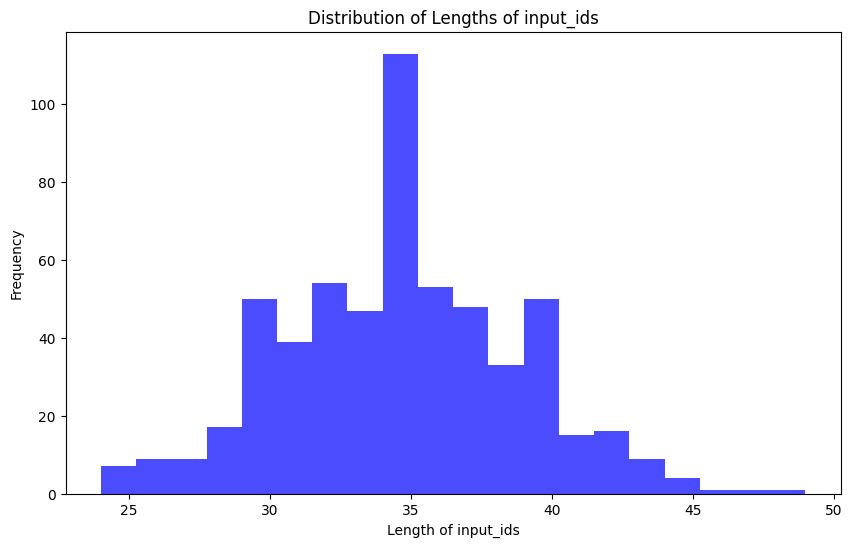

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(dataset)

In [ ]:
max_length = 64
tokenized_train_dataset = prompt_pig['train'].map(lambda v: generate_and_tokenize_prompt(v, max_length))
tokenized_val_dataset = prompt_pig['test'].map(lambda v: generate_and_tokenize_prompt(v, max_length))

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(tokenized_train_dataset[1]['input_ids'])

'<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|endoftext|>The wall phone rang loud and often. ##[PIGL]##> ethay allway onephay angray oudlay andway oftenway.<|endoftext|>'

## Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, quantization_config=bnb_config)
# no need
# model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
         load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, quantization_config=bnb_config)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model.model.embed_tokens, len(tokenizer)

(Embedding(51200, 2560), 50297)

In [ ]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
 

In [ ]:
def print_trainable_parameters(model, verbose=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if verbose:
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model, verbose=True)

model.embed_tokens.weight
model.layers.0.input_layernorm.weight
model.layers.0.input_layernorm.bias
model.layers.1.input_layernorm.weight
model.layers.1.input_layernorm.bias
model.layers.2.input_layernorm.weight
model.layers.2.input_layernorm.bias
model.layers.3.input_layernorm.weight
model.layers.3.input_layernorm.bias
model.layers.4.input_layernorm.weight
model.layers.4.input_layernorm.bias
model.layers.5.input_layernorm.weight
model.layers.5.input_layernorm.bias
model.layers.6.input_layernorm.weight
model.layers.6.input_layernorm.bias
model.layers.7.input_layernorm.weight
model.layers.7.input_layernorm.bias
model.layers.8.input_layernorm.weight
model.layers.8.input_layernorm.bias
model.layers.9.input_layernorm.weight
model.layers.9.input_layernorm.bias
model.layers.10.input_layernorm.weight
model.layers.10.input_layernorm.bias
model.layers.11.input_layernorm.weight
model.layers.11.input_layernorm.bias
model.layers.12.input_layernorm.weight
model.layers.12.input_layernorm.bias
model.

### LoRA

In [ ]:
# from peft import prepare_model_for_kbit_training

# model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "dense"
        "fc1", "fc2",
        "lm_head",
    ],
    modules_to_save=['layernorm', 'embed_tokens'],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 146,519,040 || all params: 2,926,202,880 || trainable%: 5.0071


In [ ]:
print_trainable_parameters(peft_model, verbose=True)

base_model.model.model.embed_tokens.modules_to_save.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.mlp.fc2.lora_A.default.weight
base_model.model.model.layers.0.mlp.fc2.lora_B.default.weight
base_model.model.model.layers.0.input_layernorm.modules_to_save.default.weight
base_model.model.model.layers.0.input_layernorm.modules_to_save.default.bias
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight
base_model.mod

In [ ]:
# Some Environment Setup
OUTPUT_DIR = "./results/pigl" # the path to the output directory; where model checkpoints will be saved

In [ ]:
import transformers

training_args = transformers.TrainingArguments(
        output_dir=OUTPUT_DIR,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        auto_find_batch_size=True,
        max_steps=1000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,            # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500,                # Save checkpoints every 50 steps
        eval_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
)

In [ ]:
trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=collator
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
25,6.203800,5.539662
50,4.616500,3.503492
75,3.253900,2.742589
100,2.799100,2.474653
125,2.674800,2.346745
150,2.379100,2.140998
175,2.243200,1.998835
200,2.072400,1.774961
225,1.916900,1.651165
250,1.753100,1.516914


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=1000, training_loss=1.522623779296875, metrics={'train_runtime': 3055.2499, 'train_samples_per_second': 2.618, 'train_steps_per_second': 0.327, 'total_flos': 8183988879360000.0, 'train_loss': 1.522623779296875, 'epoch': 13.88888888888889})

In [ ]:
OUTPUT_DIR

'./results/pigl'

In [ ]:
model_ckpt = OUTPUT_DIR + "/stop"

trainer.save_model(model_ckpt)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


## Reloading the Model

In [ ]:
# Downloads and unzips trained adapter
#!gdown 1zm9A2Dw6ttv61NVvI_dB_GiYjDb2fdsd
#!unzip piglatin_adapter.zip -d ./results/pigl/stop

In [ ]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): ModulesToSaveWrapper(
      (original_module): Embedding(51200, 2560)
      (modules_to_save): ModuleDict(
        (default): Embedding(51200, 2560)
      )
    )
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): lora.Linear8bitLt(
            (base_layer): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2560, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): Modul

In [ ]:
from peft import PeftModel

fine_tuned_model = PeftModel.from_pretrained(model, model_ckpt)

In [ ]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): ModulesToSaveWrapper(
          (original_module): Embedding(51200, 2560)
          (modules_to_save): ModuleDict(
            (default): Embedding(51200, 2560)
          )
        )
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2560, bias=False)
      

In [ ]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    use_fast=False,
)
eval_tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
eval_tokenizer.add_special_tokens({'additional_special_tokens': [response_template]})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [ ]:
eval_prompt = "Luke, I am your father!"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(fine_tuned_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.1)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Luke, I am your father!<|endoftext|>


In [ ]:
eval_prompt = "How are you?"
model_input = eval_tokenizer(eval_prompt+response_template, return_tensors="pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(fine_tuned_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.1)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How are you? ##[PIGL]##> eway areway uyay.<|endoftext|>


In [ ]:
def generate(model, tokenizer, prompt, response_template="", max_new_tokens=100):
    tokenized_input = tokenizer(prompt+response_template, return_tensors="pt")
    input_ids = tokenized_input["input_ids"].cuda()

    model.eval()
    generation_output = model.generate(
        input_ids=input_ids,
        #num_beams=1,
        #return_dict_in_generate=True,
        #output_scores=True,
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.1
        #do_sample=True, top_p=0.9,temperature=0.95,
        #eos_token_id=tokenizer.eos_token_id,
    )
    #seq = generation_output.sequences[0]
    seq = generation_output[0]
    output = tokenizer.decode(seq, skip_special_tokens=False)
    return output.strip()

In [ ]:
generate(fine_tuned_model, eval_tokenizer, 'how are you doing?', response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'how are you doing? ##[PIGL]##> owayhay ouyay oingday uyingkay.<|endoftext|>'

In [ ]:
sample = prompt_pig['train'][7]
generate(fine_tuned_model, eval_tokenizer, sample['prompt'], response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Hedge apples may stain your hands green. ##[PIGL]##> edhay applesmay aistray ouryay andshay eengray.<|endoftext|>'

In [ ]:
with fine_tuned_model.disable_adapter():
    print(generate(fine_tuned_model, eval_tokenizer, sample['prompt']))
    print(generate(fine_tuned_model, eval_tokenizer, sample['prompt'], response_template))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hedge apples may stain your hands green.
#*If you are using a knife, be careful not to cut yourself.
#*Wash the apple before and after cutting it.
#Cut the apple into slices. You can slice the apple horizontally or vertically. If you want to make wedges, cut the apple in half first.
#*You can also use a melon baller to scoop out small pieces of apple for a different presentation.
#Serve the hedge apples immediately. They will stay fresh for
Hedge apples may stain your hands green. ##[PIGL]##>  of the apple, and then rub it on a clean cloth to remove any excess juice.
#*If you don’t have a cloth handy, use paper towels instead. 
#*You can also wear gloves while handling the apple to prevent staining. 
#Wash the apple with warm water and dish soap. Fill a bowl or sink with warm water and add a few drops of dish soap. Place the apple in the soapy water and let it soak for about
